# Two-stream instability

1D simulation of the Two-Stream instability using an eletromagnetic code with a spectral (pseudo-spectral analytic time domain) code.

In [2]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

import em1ds as zpic
import numpy as np

nx = 120
dt = 0.1

ppc = 500
ufl = [0.2,    0.0,  0.0]
uth = [0.001,0.001,0.001]

right = zpic.Species( "right", -1.0, ppc, ufl = ufl, uth = uth )

ufl[0] = -ufl[0]
left  = zpic.Species( "left", -1.0, ppc, ufl = ufl, uth = uth )

sim = zpic.Simulation( nx, box = 4 * np.pi, dt = dt, species = [right,left] )
sim.emf.solver_type = "PSATD"

## Running the simulation

We will be running the simulation well beyond the saturation of the instability (for the default parameters this happens around $t = 20 \, \omega_n^{-1}$). We will be recording the longitudinal component of the electric field for later analysis. 

In [3]:
tmax = 60

niter = int(tmax / dt)

Ex_t = np.zeros((nx,niter))

print("\nRunning simulation up to t = {:g} ...".format(tmax))
while sim.t < tmax:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    Ex_t[:,sim.n] = sim.emf.Ex
    sim.iter()

print("\nDone.")


Running simulation up to t = 60 ...
n = 599, t = 59.9
Done.


## Final longitudinal electric field

The two-stream instability will transfer kinetic energy from the particles into the electric field. The final value of the longitudinal electric field is:

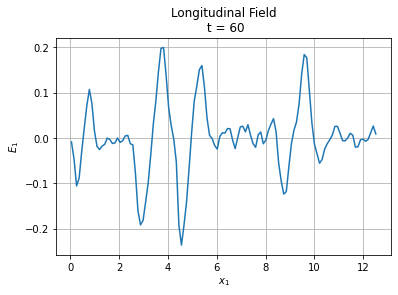

In [4]:
import matplotlib.pyplot as plt

# Plot field values at the center of the cells
xmin = sim.emf.dx/2
xmax = sim.emf.box - sim.emf.dx/2

plt.plot(np.linspace(xmin, xmax, num = sim.nx), sim.emf.Ex )
plt.xlabel("$x_1$")
plt.ylabel("$E_1$")
plt.title("Longitudinal Field\n t = {:g}".format(sim.t))
plt.grid(True)

plt.show()

## Time evolution of the electric field

Using the field values that we stored in the `Ex_t` variable we can now plot the full time evolution of the electric field.

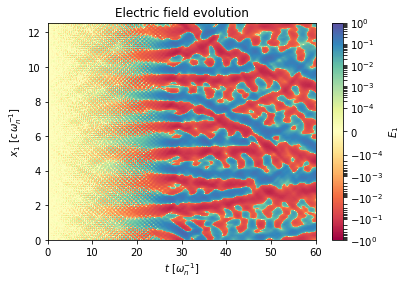

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

range = [[0,tmax],[0,sim.box]]


plt.imshow( Ex_t, interpolation = 'bilinear', origin = 'lower',
          extent = ( range[0][0], range[0][1], range[1][0], range[1][1] ),
         norm=colors.SymLogNorm(base=10,linthresh = 0.0001, vmin=-1, vmax=1),
          aspect = 'auto', cmap = 'Spectral')

plt.colorbar().set_label('$E_1$')
plt.xlabel("$t$ [$\omega_n^{-1}$]")
plt.ylabel("$x_1$ [$c\,\omega_n^{-1}$]")
plt.title("Electric field evolution")

plt.show()

## Time evolution of the power spectrum

If we now plot the time evolution of the power spectrum we can identify wich modes are growing. During the linear stage of the instability the mode with $k \sim 4$ will be the fastest growing mode (for the default parameters)

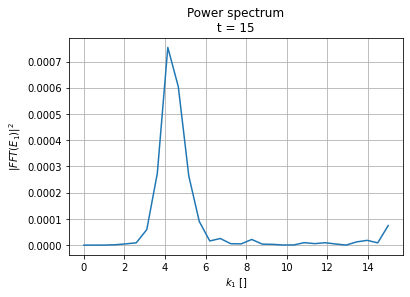

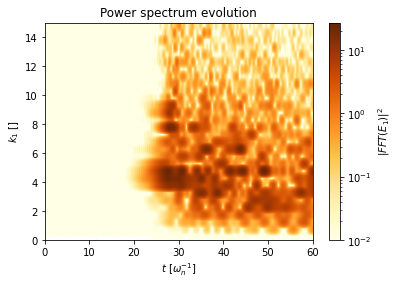

In [36]:
sp = (np.abs( np.fft.rfft2(Ex_t,axes = (0,) ) )**2)[:sim.nx//4,:]
kmax = np.pi / (sim.box / sim.nx)

t = 15.0

plt.plot(np.linspace(0, kmax/2, num = sim.nx//4), sp[:,int(t / dt)] )
plt.xlabel("$k_1$ []")
plt.ylabel("$|FFT(E_1)|^2$")
plt.title("Power spectrum\n t = {:g} ".format(t))
plt.grid(True)

plt.show()

img_range = [[0,tmax],[0,kmax/2]]

plt.imshow( sp, origin = 'lower', 
            extent = ( img_range[0][0], img_range[0][1], img_range[1][0], img_range[1][1] ),
            norm=colors.LogNorm(vmin = 1e-2),
            aspect = 'auto', cmap = 'YlOrBr')

plt.colorbar().set_label('$|FFT(E_1)|^2$')

plt.xlabel("$t$ [$\omega_n^{-1}$]")
plt.ylabel("$k_1$ []")
plt.title("Power spectrum evolution")

plt.show()

## Electric field energy evolution

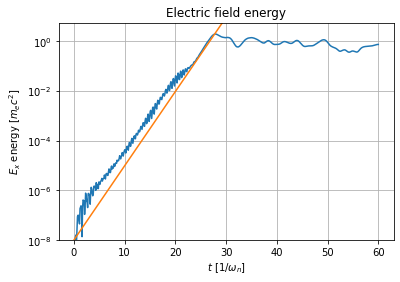

In [37]:
import matplotlib.pyplot as plt

Ex_ene = np.sum(Ex_t**2, axis = 0)

plt.plot(np.linspace(0, sim.t, num = sim.n),Ex_ene)
plt.yscale('log')
plt.ylim(ymin=1e-8)
plt.grid(True)
plt.xlabel("$t$ [$1/\omega_n$]")
plt.ylabel("$E_x$ energy [$m_e c^2$]")
plt.title("Electric field energy")
plt.plot(np.linspace(0, sim.t, num = sim.n),1e-8*np.exp(np.linspace(0, sim.t, num = sim.n)*(np.sqrt(3)/(2**(4/3)))))
plt.show()

## Final particle phasespace

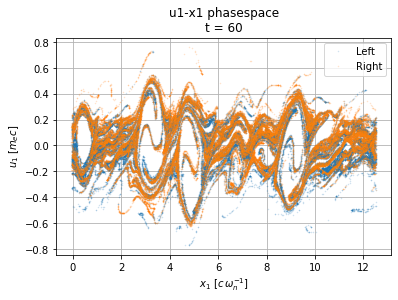

In [6]:
# Simple function to convert particle positions
x = lambda s : (s.particles['ix'] + s.particles['x']) * s.dx 

plt.plot(x(left),  left.particles['ux'],  '.', ms=1,alpha=0.2, label = "Left")
plt.plot(x(right), right.particles['ux'], '.', ms=1,alpha=0.2, label = "Right")
plt.xlabel("$x_1$ [$c\,\omega_n^{-1}$]")
plt.ylabel("$u_1$ [$m_e c$]")
plt.title("u1-x1 phasespace\nt = {:g}".format(sim.t))
plt.legend()
plt.grid(True)
plt.show()